# Time series forecasting with neural networks.

In recent years, advances in deep learning have attracted growing interest in utilising neural nets for economic time series forecasting, though currently no consensus has been achieved on the superiority of deep neural nets against the traditional methods like ARIMA and ETS.  

`GluonTS` is a newly released Python toolkit that aims to facilitate the study of deep learning models for time series forecasting. The package itself is built by  machine learning scientists from Amazon around `Apache MXNet` (an open-source deep learning framework). Apart from several ready to be trained deep learning models it contains convenient wrappers to other time series forecasting packages, such as `Forecast` or `Prophet`, which makes it easier to compare different forecasting methods.

In this project, we will use `GluonTS` to study the forecasting performance of neural time series models as well as some traditional forecasting techniques on weekly data of Brent Crude Oil Prices.

## Models

### Naive forecasting models

- **Seasonal naive**. This model simply sets each forecast to be equal to the last observed value from the same season of the year. 

###  Classical  forecasting models

- **Autoregressive integrated moving average model (ARIMA)**. This is a class of linear forecasting models extensively used in economics.  The AR part of ARIMA indicates that the evolving variable of interest is regressed on its own lagged, the MA part indicates that the regression error is a linear combination of error terms whose values occurred contemporaneously and at various times in the past, and the I (for "integrated") indicates that the data values have been replaced with the difference between their values and the previous values (and this differencing process may have been performed more than once).

- **Exponential smoothing (ETS)**. Exponential smoothing of time series data assigns exponentially decreasing weights for newest to oldest observations. In other words, the older the data, the less priority (“weight”) the data is given; newer data is seen as more relevant and is assigned more weight.

###  Neural nets

- **Feed Forward Neural Networks (FNNs)**. FNNs consist of three main building blocks: the input layer, the hidden layers and the output layer. The number of hidden layers determines the depth of the network, while the size of each layer defines its complexity in terms of neurons. FNNs provide only direct forward connections between two consecutive layers, each connection associated with a trainable parameter; given the feedfoward nature of the computation no recursive feedback is allowed.

- **Autoregressive recurrent networks (DeepAR)**. DeepAR consists of a RNN with Long short-term memory (LSTM) or Gated recurrent unit (GRU) cells and estimates parameters of a parametric distribution or a highly flexible parameterization of the quantile function based on the previous time points and co-variates.

- **Neural Quantile Regression Models**. Quantile regression is a technique for directly predicting a particular quantile of a dependent variable. These techniques have been combined with deep learning and employed in the context of time series forecasting. More specifically, within the sequenceto-sequence framework, one can employ a decoder that directly outputs a set of quantile values for each time step in the forecast horizon, and train such a model using the quantile loss function. In `GluonTS` variants of such quantile decoder models are implemented with a Convolutional Neural Network (CNN) and with a Recurrent Neural Network (RNN) as an encoder.

- **Transformer model**. The Transformer model captures the dependencies of a sequence by relying entirely on attention mechanisms. The elimination of the sequential computation makes the representation of each time step independent of all other time steps and therefore allows the parallelization of the computation. The Transformer architecture uses stacked self-attention and point-wise, fully connected layers for both the encoder and the decoder, while the decoder has an additional cross-attention layer that is applied on the encoder output.

###  Other models

- **Non-Parametric Time Series forecaster (NPTS)**. The NPTS falls into the class of simple forecasters that use one of the past observed targets as the forecast for the current time step. Unlike the naive or seasonal naive forecasters that use a fixed time index (the previous index T − 1 or the past season T − τ) as the prediction for the time step T, NPTS randomly samples a time index t ∈ {0, . . . , T − 1} in the past to generate a prediction sample for the current time step T. By sampling multiple times, one obtains a Monte Carlo sample from the predictive distribution, which can be used e.g. to compute prediction intervals.

- **Prophet**. Prophet is a procedure released by Facebook’s Core Data Science team. At its core, the Prophet procedure is an additive regression model with four main components: a piecewise linear or logistic growth curve trend, a yearly seasonal component modeled using Fourier series, a weekly seasonal component modeled using dummy variables and holidays and events component again modeled using dummy variables.

For this project, we will use only the default settings. The prediction length will be 20 time points. We will assess the accuracy of each model using various probabilistic and point metrics.

*At the time of this study, GluonTS is in a stage of active development, and we had to make some tweaks in its source code (version 0.3.2) to make all models in this mini-project fully functional on Windows OS*

In [26]:
import os
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from cycler import cycler

from gluonts.evaluation import Evaluator
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.dataset.common import ListDataset
from gluonts.model.seasonal_naive import SeasonalNaivePredictor
from gluonts.model.r_forecast import RForecastPredictor
from gluonts.model.simple_feedforward import SimpleFeedForwardEstimator
from gluonts.model.deepar import DeepAREstimator
from gluonts.model.seq2seq import (MQCNNEstimator,
                                   MQRNNEstimator)
from gluonts.model.transformer import TransformerEstimator
from gluonts.model.npts import NPTSPredictor
from gluonts.model.prophet import ProphetPredictor

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()


In [2]:
figure = {'figsize': (16, 6),
          'facecolor': '#f9f9f9',
          'subplot.wspace': 0.1,
          'dpi': 120}

colors = ["#ab5787",
          "#51b2e5",
          "#703c5c",
          "#168dd9",
          "#d190b6",
          "#00609f",
          "#d365ba",
          "#154866",
          "#666666",
          "#c4c4c4"]

axes = {'grid': True,
        'spines.left': False,
        'spines.right': False,
        'spines.top': False,
        'spines.bottom': False,
        'grid.axis': 'y',
        'facecolor': '#f9f9f9',
        'edgecolor': '#f9f9f9',
        'autolimit_mode': 'round_numbers',
        'xmargin': 0,
        'prop_cycle': cycler('color', colors)}

grid = {'color': '#979797', 'linewidth': 0.2}

tick = {'color': '#979797', 'major.size': 0, 'minor.size': 0}

plt.rc('figure', **figure)
plt.rc('axes', **axes)
plt.rc('grid', **grid)
plt.rc(('xtick', 'ytick'), **tick)


In [ ]:
df = (pd.read_csv('BRENT.csv',
                  usecols=["<CLOSE>", '<DATE>'],
                  parse_dates=['<DATE>'],
                  index_col=['<DATE>'])
        .rename(columns={'<CLOSE>': 'Price'})
        .resample('W-MON')
        .mean()
        .fillna(method='bfill')
        .assign(Logdiff=lambda x: np.log(x['Price']).diff())
        .dropna(axis=0))

df.index.names = ['Date']


In [4]:
df.describe()


,Price,Logdiff
count,1024.000000,1024.000000
mean,65.131064,0.000934
std,30.186376,0.048890
min,17.150000,-0.297136
25%,40.122500,-0.023305
50%,61.605000,0.003877
75%,86.562500,0.029152
max,144.980000,0.218604


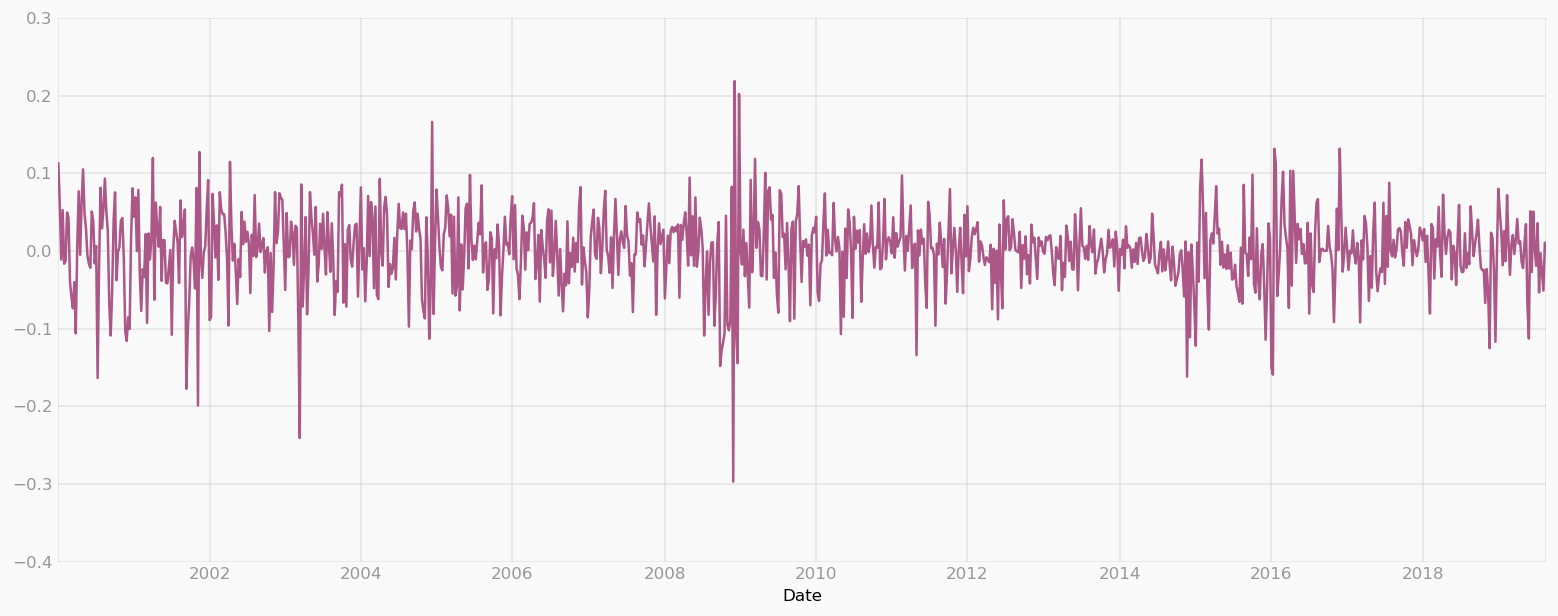

In [5]:
df['Logdiff'].plot();


In [6]:
def plot_forecasts(tss, forecasts, num_past=150):
    for target, forecast in zip(tss, forecasts):
        ax = target[-num_past:].plot()
        forecast.plot(color='#666666')
        plt.legend(["observations",
                    "median prediction",
                    "90% confidence interval",
                    "50% confidence interval"])
        plt.show()

In [7]:
models = {'naive': [
              SeasonalNaivePredictor
          ],
          'classic': [
              'arima',
              'ets',
          ],
          'nnets': [
              SimpleFeedForwardEstimator,
              DeepAREstimator,
              MQCNNEstimator,
              MQRNNEstimator,
              TransformerEstimator,
          ],
          'other': [
              NPTSPredictor,
              ProphetPredictor,
          ]}
params = {'freq': 'W',
          'prediction_length': 20,
          'metrics': [
              'mean_wQuantileLoss',
              'wQuantileLoss[0.5]',
              'wQuantileLoss[0.9]',
              'NRMSE',
              'sMAPE',
              'MASE',
          ]}


In [8]:
def generate_results(models, params, train, test):

    def res_to_pandas(model_class, model_name):

        forecast_it, ts_it = make_evaluation_predictions(test,
                                                         predictor=predictor,
                                                         num_eval_samples=100)

        agg_metrics, item_metrics = Evaluator()(ts_it, forecast_it)

        res_t = res.append(pd.DataFrame(agg_metrics,
                                        index=[[model_class], [model_name]]))

        return res_t[metrics]

    res = pd.DataFrame()

    nn_predictors = []

    metrics = params['metrics']

    if models['naive']:

        for model in models['naive']:

            predictor = model(freq=freq,
                              prediction_length=prediction_length)

            res = res_to_pandas('Naive', type(predictor).__name__)

    if models['classic']:

        for model in models['classic']:

            predictor = RForecastPredictor(freq=freq,
                                           prediction_length=prediction_length,
                                           method_name=model)

            res = res_to_pandas('Classic', model.capitalize())

    if models['nnets']:

        for model in models['nnets']:

            estimator = model(freq=freq,
                              prediction_length=prediction_length)

            predictor = estimator.train(train)

            nn_predictors.append(predictor)

            res = res_to_pandas('NNets', type(estimator).__name__)

    if models['other']:

        for model in models['other']:

            predictor = model(freq=freq,
                              prediction_length=prediction_length)

            res = res_to_pandas('Other', type(predictor).__name__)

    return res, nn_predictors


In [9]:
train, test = df['Logdiff'].iloc[:-20], df['Logdiff']


In [10]:
freq = 'W'
prediction_length = 20
start = train.index[0]

metrics = [
    'mean_wQuantileLoss',
    'wQuantileLoss[0.5]',
    'wQuantileLoss[0.9]',
    'NRMSE',
    'sMAPE',
    'MASE'
]

models = {'naive': [
              SeasonalNaivePredictor
          ],
          'classic': [
              'arima',
              'ets',
          ],
          'nnets': [
              SimpleFeedForwardEstimator,
              DeepAREstimator,
              MQCNNEstimator,
              MQRNNEstimator,
              TransformerEstimator,
          ],
          'other': [
              NPTSPredictor,
              ProphetPredictor,
          ]}

params = {'freq': freq,
          'prediction_length': prediction_length,
          'metrics': metrics}

In [11]:
train_ds = ListDataset([{'target': train.squeeze(), 'start': start}],
                       freq=freq)
test_ds = ListDataset([{'target': test.squeeze(), 'start': start}],
                       freq=freq)


In [42]:
%%capture
results, predictors = generate_results(models=models,
                                       params=params,
                                       train=train_ds,
                                       test=test_ds)


INFO:root:Start model training
INFO:root:Number of parameters in SimpleFeedForwardTrainingNetwork: 843
INFO:root:Epoch[0] Learning rate is 0.001
INFO:root:Epoch[0] Elapsed time 0.266 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=-1.621002
INFO:root:Epoch[1] Learning rate is 0.001
INFO:root:Epoch[1] Elapsed time 0.316 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=-1.668507
INFO:root:Epoch[2] Learning rate is 0.001
INFO:root:Epoch[2] Elapsed time 0.226 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=-1.684984
INFO:root:Epoch[3] Learning rate is 0.001
INFO:root:Epoch[3] Elapsed time 0.254 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=-1.666146
INFO:root:Epoch[4] Learning rate is 0.001
INFO:root:Epoch[4] Elapsed time 0.241 seconds
INFO:root:Epoch[4] Evaluation metric 'epoch_loss'=-1.689930
INFO:root:Epoch[5] Learning rate is 0.001
INFO:root:Epoch[5] Elapsed time 0.222 seconds
INFO:root:Epoch[5] Evaluation metric 'epoch_loss'=-1.692791
INFO:root

INFO:root:Epoch[4] Evaluation metric 'epoch_loss'=-2.227451
INFO:root:Epoch[5] Learning rate is 0.001
INFO:root:Epoch[5] Elapsed time 2.839 seconds
INFO:root:Epoch[5] Evaluation metric 'epoch_loss'=-2.336713
INFO:root:Epoch[6] Learning rate is 0.001
INFO:root:Epoch[6] Elapsed time 2.604 seconds
INFO:root:Epoch[6] Evaluation metric 'epoch_loss'=-2.390954
INFO:root:Epoch[7] Learning rate is 0.001
INFO:root:Epoch[7] Elapsed time 3.011 seconds
INFO:root:Epoch[7] Evaluation metric 'epoch_loss'=-2.492179
INFO:root:Epoch[8] Learning rate is 0.001
INFO:root:Epoch[8] Elapsed time 2.601 seconds
INFO:root:Epoch[8] Evaluation metric 'epoch_loss'=-2.567264
INFO:root:Epoch[9] Learning rate is 0.001
INFO:root:Epoch[9] Elapsed time 2.537 seconds
INFO:root:Epoch[9] Evaluation metric 'epoch_loss'=-2.593923
INFO:root:Epoch[10] Learning rate is 0.001
INFO:root:Epoch[10] Elapsed time 2.559 seconds
INFO:root:Epoch[10] Evaluation metric 'epoch_loss'=-2.646074
INFO:root:Epoch[11] Learning rate is 0.001
INFO:r

INFO:root:Epoch[11] Elapsed time 1.936 seconds
INFO:root:Epoch[11] Evaluation metric 'epoch_loss'=0.000264
INFO:root:Epoch[12] Learning rate is 0.001
INFO:root:Epoch[12] Elapsed time 2.231 seconds
INFO:root:Epoch[12] Evaluation metric 'epoch_loss'=0.000235
INFO:root:Epoch[13] Learning rate is 0.001
INFO:root:Epoch[13] Elapsed time 1.982 seconds
INFO:root:Epoch[13] Evaluation metric 'epoch_loss'=0.000216
INFO:root:Epoch[14] Learning rate is 0.001
INFO:root:Epoch[14] Elapsed time 1.771 seconds
INFO:root:Epoch[14] Evaluation metric 'epoch_loss'=0.000201
INFO:root:Epoch[15] Learning rate is 0.001
INFO:root:Epoch[15] Elapsed time 1.861 seconds
INFO:root:Epoch[15] Evaluation metric 'epoch_loss'=0.000190
INFO:root:Epoch[16] Learning rate is 0.001
INFO:root:Epoch[16] Elapsed time 1.705 seconds
INFO:root:Epoch[16] Evaluation metric 'epoch_loss'=0.000181
INFO:root:Epoch[17] Learning rate is 0.001
INFO:root:Epoch[17] Elapsed time 1.638 seconds
INFO:root:Epoch[17] Evaluation metric 'epoch_loss'=0.

INFO:root:Epoch[18] Learning rate is 0.001
INFO:root:Epoch[18] Elapsed time 1.281 seconds
INFO:root:Epoch[18] Evaluation metric 'epoch_loss'=0.000698
INFO:root:Epoch[19] Learning rate is 0.001
INFO:root:Epoch[19] Elapsed time 1.483 seconds
INFO:root:Epoch[19] Evaluation metric 'epoch_loss'=0.000656
INFO:root:Epoch[20] Learning rate is 0.001
INFO:root:Epoch[20] Elapsed time 1.491 seconds
INFO:root:Epoch[20] Evaluation metric 'epoch_loss'=0.000617
INFO:root:Epoch[21] Learning rate is 0.001
INFO:root:Epoch[21] Elapsed time 1.359 seconds
INFO:root:Epoch[21] Evaluation metric 'epoch_loss'=0.000583
INFO:root:Epoch[22] Learning rate is 0.001
INFO:root:Epoch[22] Elapsed time 1.392 seconds
INFO:root:Epoch[22] Evaluation metric 'epoch_loss'=0.000552
INFO:root:Epoch[23] Learning rate is 0.001
INFO:root:Epoch[23] Elapsed time 1.194 seconds
INFO:root:Epoch[23] Evaluation metric 'epoch_loss'=0.000523
INFO:root:Epoch[24] Learning rate is 0.001
INFO:root:Epoch[24] Elapsed time 1.238 seconds
INFO:root:

INFO:root:Epoch[24] Evaluation metric 'epoch_loss'=-2.505979
INFO:root:Epoch[25] Learning rate is 0.001
INFO:root:Epoch[25] Elapsed time 4.285 seconds
INFO:root:Epoch[25] Evaluation metric 'epoch_loss'=-2.527043
INFO:root:Epoch[26] Learning rate is 0.001
INFO:root:Epoch[26] Elapsed time 4.561 seconds
INFO:root:Epoch[26] Evaluation metric 'epoch_loss'=-2.557932
INFO:root:Epoch[27] Learning rate is 0.001
INFO:root:Epoch[27] Elapsed time 4.088 seconds
INFO:root:Epoch[27] Evaluation metric 'epoch_loss'=-2.572175
INFO:root:Epoch[28] Learning rate is 0.001
INFO:root:Epoch[28] Elapsed time 3.913 seconds
INFO:root:Epoch[28] Evaluation metric 'epoch_loss'=-2.574682
INFO:root:Epoch[29] Learning rate is 0.001
INFO:root:Epoch[29] Elapsed time 4.000 seconds
INFO:root:Epoch[29] Evaluation metric 'epoch_loss'=-2.574908
INFO:root:Epoch[30] Learning rate is 0.001
INFO:root:Epoch[30] Elapsed time 4.250 seconds
INFO:root:Epoch[30] Evaluation metric 'epoch_loss'=-2.638519
INFO:root:Epoch[31] Learning rate

In [43]:
def highlight_min(s):
    is_min = s == s.min()
    return ['background-color: #c4c4c4' if v else '' for v in is_min]

results.style.apply(highlight_min)

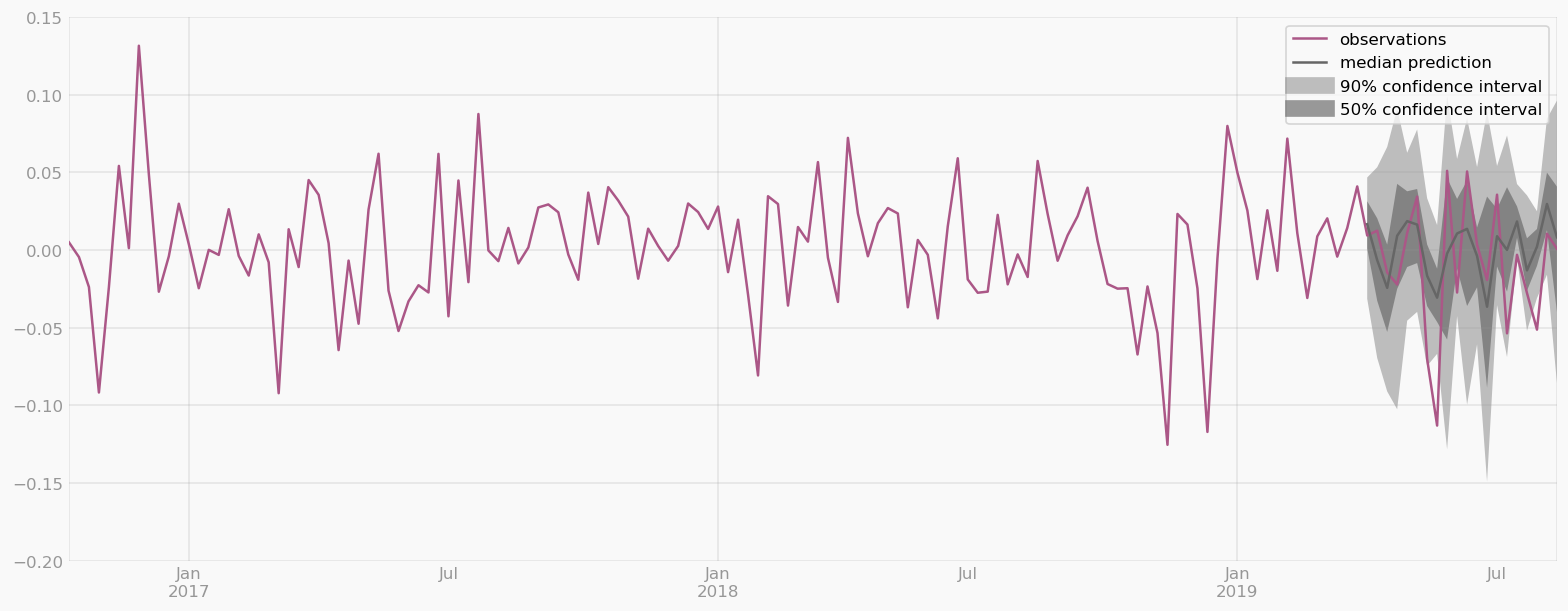

In [44]:
forecast_it, ts_it = make_evaluation_predictions(test_ds,
                                                 predictor=predictors[0],
                                                 num_eval_samples=100)
forecasts = list(forecast_it)
tss = list(ts_it)
plot_forecasts(tss, forecasts)

According to our study, the simple feedforward network outperforms not only the classical forecasting models but also its more sophisticated counterparts, such as DeepAR. Actually, this outcome is not unusual, as similar results pop up quite often in empirical research on the subject. Of course, no solid decision can be made even on this particular dataset as models tuning and proper time series cross-validation is needed to ensure the robustness of the results.